# **Set up and Download Dataset**

In [1]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.


In [2]:
!pip install --upgrade --no-cache-dir gdown

# !gdown --id 1yxo_HLz3Nc-SxQeY61cMtbsVHWzJ8S20 --output "{workspace_dir}/Data.zip"
!gdown --id 1aGNqHgyDV50KFwdlfBj4tws8HAdABw83 --output "{workspace_dir}/Data.zip"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1aGNqHgyDV50KFwdlfBj4tws8HAdABw83
From (redirected): https://drive.google.com/uc?id=1aGNqHgyDV50KFwdlfBj4tws8HAdABw83&confirm=t&uuid=701f831f-06a8-4363-8ae4-5a24bae2f3d6
To: /content/Data.zip
100% 745M/745M [00:09<00:00, 80.5MB/s]


In [3]:
!unzip -q "{workspace_dir}/Data.zip" -d "{workspace_dir}/"

# **Import**

In [ ]:
# System and file handling
import os
import glob
import zipfile
from google.colab import files

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

# Image processing
from PIL import Image
from torchvision import transforms

# Utilities and visualization
import cv2
import functools
import matplotlib.pyplot as plt
import math
import numpy as np
from tqdm import tqdm
from qqdm.notebook import qqdm

# **Data Preprocess Tool**

In [5]:
class StainDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.original_path = os.path.join(root_dir, 'Original')
        self.stained_path = os.path.join(root_dir, 'Stained')
        self.mask_path = os.path.join(root_dir, 'Mask')
        self.images = os.listdir(self.original_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        original_img_path = os.path.join(self.original_path, img_name)
        stained_img_path = os.path.join(self.stained_path, img_name)
        mask_img_path = os.path.join(self.mask_path, img_name)

        original_image = Image.open(original_img_path)
        stained_image = Image.open(stained_img_path)
        mask_image = Image.open(mask_img_path).convert('L')  # 讀取為灰階圖像

        if self.transform:
            original_image = self.transform(original_image)
            stained_image = self.transform(stained_image)

        if self.mask_transform:
            mask_image = self.mask_transform(mask_image)

        return original_image, stained_image, mask_image

# 定義轉換
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

mask_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # 將單通道 mask 轉為 tensor，但不進行 Normalize
])

# **Model**

## **Generator**

### **Get Generator**

In [6]:
def get_generator(type='concat_conv_deconv'):
  if type == 'concat_conv_deconv':
    return Gen_concat_conv_deconv()
  elif type == 'conv_concat_deconv':
    return Gen_conv_concat_deconv()
  elif type == 'unet-64':
    return UnetGenerator(input_nc=4, output_nc=3, num_downs=6, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False)

### **Auto-encoder**

In [7]:
class Gen_conv_concat_deconv(nn.Module):
  def __init__(self):
    super().__init__()

    def conv_bn_LRelu(in_dim, out_dim):
      return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace=True),
      )

    def deconv_bn_Relu(in_dim, out_dim, output_layer=False):
      if output_layer:
        return nn.Sequential(
          nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.Tanh()
        )
      return nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(inplace=True),
      )

    self.stained_img_encoder = nn.Sequential(
      conv_bn_LRelu(4, 64),
      conv_bn_LRelu(64, 128),
      conv_bn_LRelu(128, 256),
      nn.Flatten(),
      nn.Linear(256 * 8 * 8, 512)
    )

    self.noise_encoder = nn.Sequential(
      nn.Linear(100, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 512)
    )

    self.combined_model = nn.Sequential(
      nn.Linear(1024, 256 * 8 * 8),  # 新增的線性層
      nn.ReLU(inplace=True),
      nn.Unflatten(1, (256, 8, 8)),  # 重塑為 4D 張量
      deconv_bn_Relu(256, 128),
      deconv_bn_Relu(128, 64),
      deconv_bn_Relu(64, 3, output_layer=True)
    )
  def forward(self, z, stained_imgs, mask):
    combined_input = torch.cat([stained_imgs, mask], dim=1)
    encoded_img = self.stained_img_encoder(combined_input)
    encoded_noise = self.noise_encoder(z)
    concated_noise = torch.cat([encoded_img, encoded_noise], dim=1)
    output = self.combined_model(concated_noise)
    return output  # 重塑輸出成圖像的尺寸

class Gen_concat_conv_deconv(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc = nn.Linear(100, 3 * 64 * 64)
    self.attention = nn.Sequential(
      nn.Conv2d(7, 3, kernel_size=3, padding=1),
      nn.Sigmoid()
    )

    def conv_bn_LRelu(in_dim, out_dim):
      return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace=True),
      )

    def deconv_bn_Relu(in_dim, out_dim, output_layer=False):
      if output_layer:
        return nn.Sequential(
          nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.Tanh()
        )
      return nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(inplace=True),
      )

    self.combined_model = nn.Sequential(
      conv_bn_LRelu(3, 64),
      conv_bn_LRelu(64, 128),
      conv_bn_LRelu(128, 256),
      deconv_bn_Relu(256, 128),
      deconv_bn_Relu(128, 64),
      deconv_bn_Relu(64, 3, output_layer=True)
    )
  def forward(self, z, stained_imgs, mask):
    latent_v = self.fc(z)
    latent_v = latent_v.view(-1, 3, 64, 64)
    combined_input = torch.cat([stained_imgs, mask, latent_v], dim=1)
    attention = self.attention(combined_input)
    combined_input = stained_imgs * (1-attention) + latent_v * attention
    output = self.combined_model(combined_input)
    return output  # 重塑輸出成圖像的尺寸

# 修改生成器以整合擴散模型
class Gen_with_Diffusion(nn.Module):
    def __init__(self, base_generator, diffusion_model, refine_net):
        super(Gen_with_Diffusion, self).__init__()
        self.base_generator = base_generator  # 原本的生成器
        self.diffusion_model = diffusion_model  # 擴散模型
        self.refine_net = refine_net  # Boundary-aware RefineNet

    def forward(self, z, stained_imgs, mask):
        # 使用生成器生成初步影像
        gen_imgs = self.base_generator(z, stained_imgs, mask)

        # 使用擴散模型進一步去噪
        refined_imgs = self.diffusion_model(gen_imgs, mask)

        # 使用 Boundary-aware RefineNet 修復邊界
        final_imgs = self.refine_net(refined_imgs, mask)

        return final_imgs


### **Diffusion model**

In [8]:
class ResBlock(nn.Module):
    """Residual Block with two convolutional layers."""
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

class DiffusionModel(nn.Module):
    def __init__(self, num_steps=5):
        super(DiffusionModel, self).__init__()
        self.num_steps = num_steps

        # Diffusion blocks
        def diffusion_block(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2, inplace=True)
            )

        # Attention mechanism
        def spatial_attention(dim):
            return nn.Sequential(
                nn.Conv2d(dim, 1, kernel_size=1),
                nn.Sigmoid()
            )

        # Model architecture
        self.initial_block = diffusion_block(4, 64)  # Input: stained_imgs + mask
        self.res_block1 = ResBlock(64)
        self.res_block2 = ResBlock(64)
        self.attention = spatial_attention(64)  # Spatial attention layer
        self.final_block = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Output: restored image
        )

    def forward(self, x, mask):
        """
        x: Initial generated image
        mask: Mask indicating regions to restore (single channel)
        """
        # Ensure mask is 4D [batch_size, 1, height, width]
        if mask.dim() == 3:
            mask = mask.unsqueeze(1)

        # Extend mask to match the input shape
        mask = mask.expand(-1, 3, -1, -1)  # Same shape as x

        # Multi-step denoising process
        for step in range(self.num_steps):
            # Dynamically adjust noise level
            noise_level = 0.1 * (1 - (step / self.num_steps))
            noise = torch.randn_like(x) * noise_level

            # Add noise to input
            x_noisy = x + noise

            # Combine input and mask
            combined_input = torch.cat([x_noisy, mask[:, :1, :, :]], dim=1)  # 4-channel input

            # Forward pass through model
            x_restored = self.initial_block(combined_input)
            x_restored = self.res_block1(x_restored)
            x_restored = self.res_block2(x_restored)

            # Apply spatial attention
            attention_weights = self.attention(x_restored)
            x_restored = x_restored * attention_weights

            # Final restoration
            x_restored = self.final_block(x_restored)

            # Update x only in mask regions
            x = x * (1 - mask) + x_restored * mask

        return x

### **Unet(Generator)**

In [9]:
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, latent_dim=100, num_downs=6, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()

        self.inner_nc = ngf * min(2 ** (num_downs - 1), 8)

        self.latent_processor = nn.Sequential(
            nn.Linear(latent_dim, self.inner_nc),
            nn.ReLU(True)
        )

        # 64x64 -> 32x32
        self.first_conv = nn.Conv2d(input_nc, ngf, kernel_size=4,
                                  stride=2, padding=1, bias=use_bias)

        # 下採樣路徑: 32x32 -> 1x1
        mult = 1
        for i in range(num_downs - 1):
            mult_prev = mult
            mult = min(2 ** (i + 1), 8)

            if i == num_downs - 2:  # 最內層
                down_block = nn.Sequential(
                    nn.LeakyReLU(0.2, True),
                    nn.Conv2d(ngf * mult_prev, ngf * mult,
                             kernel_size=4, stride=2, padding=1, bias=use_bias)
                )
            else:
                down_block = nn.Sequential(
                    nn.LeakyReLU(0.2, True),
                    nn.Conv2d(ngf * mult_prev, ngf * mult,
                             kernel_size=4, stride=2, padding=1, bias=use_bias),
                    norm_layer(ngf * mult)
                )
            self.down_layers.append(down_block)

        # 上採樣路徑改為6層: 1x1 -> 64x64
        for i in range(num_downs):  # 注意這裡改為 num_downs
            mult_prev = min(2 ** (num_downs - i - 1), 8)
            mult = min(2 ** (num_downs - i - 2), 8) if i < num_downs - 1 else 1

            if i == 0:  # 最內層: 1x1 -> 2x2
                up_block = nn.Sequential(
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * mult_prev * 2, ngf * mult,
                                     kernel_size=4, stride=2, padding=1, bias=use_bias),
                    norm_layer(ngf * mult)
                )
            elif i == num_downs - 1:  # 最外層: 32x32 -> 64x64
                up_block = nn.Sequential(
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * 2, output_nc,  # 輸入是通道數是ngf*2因為有skip connection
                                     kernel_size=4, stride=2, padding=1)
                )
            else:
                up_block = nn.Sequential(
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * mult_prev * 2, ngf * mult,
                                     kernel_size=4, stride=2, padding=1, bias=use_bias),
                    norm_layer(ngf * mult)
                )
                if use_dropout and i < num_downs - 3:
                    up_block = nn.Sequential(up_block, nn.Dropout(0.5))
            self.up_layers.append(up_block)

    def forward(self, z, stained_imgs, mask):
        features = []

        # 串接輸入
        x = torch.cat([stained_imgs, mask], dim=1)


        # 下採樣路徑
        x = self.first_conv(x)  # 64x64 -> 32x32
        features.append(x)

        for i, down_layer in enumerate(self.down_layers):
            x = down_layer(x)
            features.append(x)

        # 處理latent
        latent_features = self.latent_processor(z)
        latent_features = latent_features.view(-1, self.inner_nc, 1, 1)

        # 串接latent
        x = torch.cat([x, latent_features], 1)

        # 上採樣路徑
        for i, up_layer in enumerate(self.up_layers):
            if i == 0:
                x = up_layer(x)
            else:
                x = up_layer(torch.cat([x, features[-(i+1)]], 1))

        return x

### **Unet(Boundary Aware)**

In [10]:
import torch
import torch.nn as nn
import functools

class UnetBD(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super().__init__()

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()

        self.first_conv = nn.Conv2d(input_nc, ngf, kernel_size=4, stride=2, padding=1, bias=use_bias)

        # 下採樣路徑不變
        mult = 1
        for i in range(num_downs - 1):
            mult_prev = mult
            mult = min(2 ** (i + 1), 8)

            if i == num_downs - 2:
                down_block = nn.Sequential(
                    nn.LeakyReLU(0.2, True),
                    nn.Conv2d(ngf * mult_prev, ngf * mult, kernel_size=4, stride=2, padding=1, bias=use_bias)
                )
            else:
                down_block = nn.Sequential(
                    nn.LeakyReLU(0.2, True),
                    nn.Conv2d(ngf * mult_prev, ngf * mult, kernel_size=4, stride=2, padding=1, bias=use_bias),
                    norm_layer(ngf * mult)
                )
            self.down_layers.append(down_block)

        # 修改上採樣路徑，使用 num_downs 而不是 num_downs - 1
        for i in range(num_downs):
            mult_prev = min(2 ** (num_downs - i - 1), 8)
            mult = min(2 ** (num_downs - i - 2), 8) if i < num_downs - 1 else 1

            if i == 0:
                up_block = nn.Sequential(
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * mult_prev, ngf * mult, kernel_size=4, stride=2, padding=1, bias=use_bias),
                    norm_layer(ngf * mult)
                )
            elif i == num_downs - 1:  # 最後一層
                up_block = nn.Sequential(
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * 2, output_nc, kernel_size=4, stride=2, padding=1)
                )
            else:
                up_block = nn.Sequential(
                    nn.ReLU(True),
                    nn.ConvTranspose2d(ngf * mult_prev * 2, ngf * mult, kernel_size=4, stride=2, padding=1, bias=use_bias),
                    norm_layer(ngf * mult)
                )
                if use_dropout and i < num_downs - 3:
                    up_block = nn.Sequential(up_block, nn.Dropout(0.5))
            self.up_layers.append(up_block)

    def forward(self, x):
        features = []

        x = self.first_conv(x)
        features.append(x)

        for down_layer in self.down_layers:
            x = down_layer(x)
            features.append(x)

        for i, up_layer in enumerate(self.up_layers):
            if i == 0:
                x = up_layer(x)
            else:
                x = up_layer(torch.cat([x, features[-(i+1)]], 1))

        return x

### **Boundary Aware**

In [ ]:
class BoundaryAwareRefineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.refine = UnetBD(5, 3, 6)

    def forward(self, x, mask):
        # 將 mask 轉換為 numpy array 進行處理
        mask_np = mask.cpu().detach().numpy()
        if len(mask_np.shape) == 4:  # 如果是批次數據
            B, C, H, W = mask_np.shape
            penumbra_masks = []

            # 對每個批次的 mask 進行處理
            for b in range(B):
                current_mask = mask_np[b, 0]  # 假設 mask 是單通道的

                # 創建 kernel
                kernel = np.ones((7, 7), np.uint8)

                # 進行膨脹和腐蝕操作
                dilated_mask = cv2.dilate(current_mask, kernel, iterations=1)
                eroded_mask = cv2.erode(current_mask, kernel, iterations=1)

                # 計算半影遮罩
                penumbra_mask = dilated_mask - eroded_mask
                penumbra_masks.append(penumbra_mask)

            # 將處理後的遮罩轉回 tensor
            penumbra_mask = torch.FloatTensor(np.array(penumbra_masks)).unsqueeze(1)

            # 如果使用 GPU，將遮罩移到相應設備
            if x.is_cuda:
                penumbra_mask = penumbra_mask.cuda()

        else:  # 如果不是批次數據
            mask_np = mask_np[0]  # 假設 mask 是單通道的

            # 創建 kernel
            kernel = np.ones((7, 7), np.uint8)

            # 進行膨脹和腐蝕操作
            dilated_mask = cv2.dilate(mask_np, kernel, iterations=1)
            eroded_mask = cv2.erode(mask_np, kernel, iterations=1)

            # 計算半影遮罩
            penumbra_mask = dilated_mask - eroded_mask

            # 將處理後的遮罩轉回 tensor
            penumbra_mask = torch.FloatTensor(penumbra_mask).unsqueeze(0).unsqueeze(0)

            # 如果使用 GPU，將遮罩移到相應設備
            if x.is_cuda:
                penumbra_mask = penumbra_mask.cuda()

        # 將半影遮罩加入到輸入，構成 5 通道
        combined_input = torch.cat([x, penumbra_mask, mask], dim=1)

        # 邊界修復
        refined_output = self.refine(combined_input)

        return refined_output

## **Discriminator**

In [12]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    def conv_bn_lrelu(in_dim, out_dim):
      return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, 5, 2, 2),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
      )

    self.model = nn.Sequential(
        # 輸入圖像尺寸為3 x 64 X 64
      nn.Conv2d(3, 64, 5, 2, 2),
      nn.LeakyReLU(0.2, inplace=True),

      conv_bn_lrelu(64, 128),
      conv_bn_lrelu(128, 256),
      conv_bn_lrelu(256, 512),
      nn.Conv2d(512, 1, 4),
      nn.Sigmoid()
    )

  def forward(self, img, mask):
    # 只在 mask=1 的區域進行判別
    masked_img = img * mask
    y = self.model(masked_img)
    y = y.view(-1, 1)
    return y

# **Tools**

## **Save sample image**

In [13]:
def save_image(gen_imgs, epoch, iter):
    """將生成的圖像保存成一張圖"""
    gen_imgs = gen_imgs.cpu().detach().numpy()
    gen_imgs = (gen_imgs + 1) / 2  # 假設生成圖像範圍在 [-1, 1]，先歸一化到 [0, 1]

    # 將圖像裁剪到 [0, 1] 範圍，防止 imshow 超出範圍
    gen_imgs = np.clip(gen_imgs, 0, 1)

    # 計算行數和列數
    n = gen_imgs.shape[0]
    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            if cnt < n:
                ax = axs[i, j] if rows > 1 else axs[j]
                ax.imshow(np.transpose(gen_imgs[cnt], (1, 2, 0)))
                ax.axis('off')
                cnt += 1
            else:
                ax = axs[i, j] if rows > 1 else axs[j]
                ax.axis('off')

    if not os.path.exists('./val_imgs'):
        os.makedirs('./val_imgs')
    plt.savefig(f'./val_imgs/Epoch_{epoch}_iter_{iter}.png')
    plt.show()
    plt.close()

## **RMSE Evaluation**

In [14]:
def rmse(predictions, targets, mask):
    return np.sqrt((((predictions - targets) * mask) ** 2).mean()), \
    np.sqrt((((predictions - targets) * (1 - mask)) ** 2).mean()), \
    np.sqrt(((predictions - targets) ** 2).mean())

# **Loss Function**

## **Boundary Loss**

In [15]:
class BoundaryLoss(nn.Module):
    def __init__(self):
        super(BoundaryLoss, self).__init__()

    def laplacian_gradient(self, x):
        """計算拉普拉斯梯度
        Args:
            x: 輸入張量 [B, C, H, W]
        Returns:
            梯度張量
        """
        # 定義拉普拉斯卷積核
        laplacian_kernel = torch.tensor([
            [0, 1, 0],
            [1, -4, 1],
            [0, 1, 0]
        ], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        if x.is_cuda:
            laplacian_kernel = laplacian_kernel.cuda()

        # 對每個通道進行卷積
        channels = []
        for channel in range(x.shape[1]):
            pad = F.pad(x[:, channel:channel+1], (1, 1, 1, 1), mode='reflect')
            grad = F.conv2d(pad, laplacian_kernel)
            channels.append(grad)

        return torch.cat(channels, dim=1)

    def forward(self, I_pred, I_s, I_gt, mask):
        """計算邊界 loss
        Args:
            I_pred: 預測的無陰影圖像
            I_s: 有陰影的圖像
            I_gt: 真實的無陰影圖像
            mask: 陰影區域遮罩 (1表示陰影區域)
        """
        # 計算梯度
        grad_pred = self.laplacian_gradient(I_pred)
        grad_s = self.laplacian_gradient(I_s)
        grad_gt = self.laplacian_gradient(I_gt)

        # 計算非陰影區域的梯度損失
        non_stained_loss = F.mse_loss(grad_pred, grad_s, reduction='none') * (1 - mask)

        # 計算陰影區域的梯度損失
        stained_loss = F.mse_loss(grad_pred, grad_gt, reduction='none') * mask

        # 合併損失
        total_loss = non_stained_loss + stained_loss

        # 返回平均損失
        return total_loss.mean()

## **Adversarial Loss**

In [16]:
class AdversarialLoss(nn.Module):
    def __init__(self):
        super(AdversarialLoss, self).__init__()
        self.loss = nn.BCELoss()

    def forward(self, y_pred, y_true):
        return self.loss(y_pred, y_true)

# **Initialization**

## **Hyperperameters**

In [17]:
epochs = 13
batch_size = 8
lambda_l1 = 10
lambda_bd = 0.1
lr_g = 2e-4
lr_d = 2e-4
g_type = 'unet-64'  # [concat_conv_deconv, conv_concat_deconv, unet-64]
latent_dim = 100  # 噪聲向量的維度
sample_interval = 1500  # 每隔多少批次儲存一次生成的圖像

## **Model Initialization and Training Setup**

In [18]:
# 檢查是否可以使用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化Generator、Diffusion Model和RefineNet
base_generator = get_generator(g_type).to(device)
diffusion_model = DiffusionModel(num_steps=5).to(device)
refine_net = BoundaryAwareRefineNet().to(device)
discriminator = Discriminator().to(device)

# 整合為新的生成器模型
generator = Gen_with_Diffusion(base_generator, diffusion_model, refine_net).to(device)

# 將模型調成訓練模式
generator.train()
discriminator.train()

# 初始化Loss function
adversarial_loss = AdversarialLoss()  # 對抗損失(只計算mask範圍)
l1_loss = torch.nn.L1Loss()  # L1損失(Global)
bd_loss = BoundaryLoss()  # Boundary-aware損失

# 設定優化器
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

## **Create Dataset**

In [19]:
# 創建數據集
dataset = StainDataset(root_dir=f'{workspace_dir}/Data', transform=image_transform, mask_transform=mask_transform)


# 分割train data 和 test data
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 創建DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## **Load Model Weights**

In [20]:
# 權重檔案路徑
gen_weight_path = 'generator.pth'
disc_weight_path = 'discriminator.pth'

# 嘗試加載權重
if os.path.exists(gen_weight_path) and os.path.exists(disc_weight_path):
    print("載入先前的模型權重...")
    generator.load_state_dict(torch.load(gen_weight_path))
    discriminator.load_state_dict(torch.load(disc_weight_path))
else:
    print("未找到模型權重，從頭開始訓練...")

未找到模型權重，從頭開始訓練...


# **Training**

   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch                                      
 7131/7131  00:19:59<00:00:00  5.94it/s  0.4711  1.9365    1                                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Epoch [1/13] Batch 0/7131 \ Loss D: 0.7053, Loss G: 13.3598


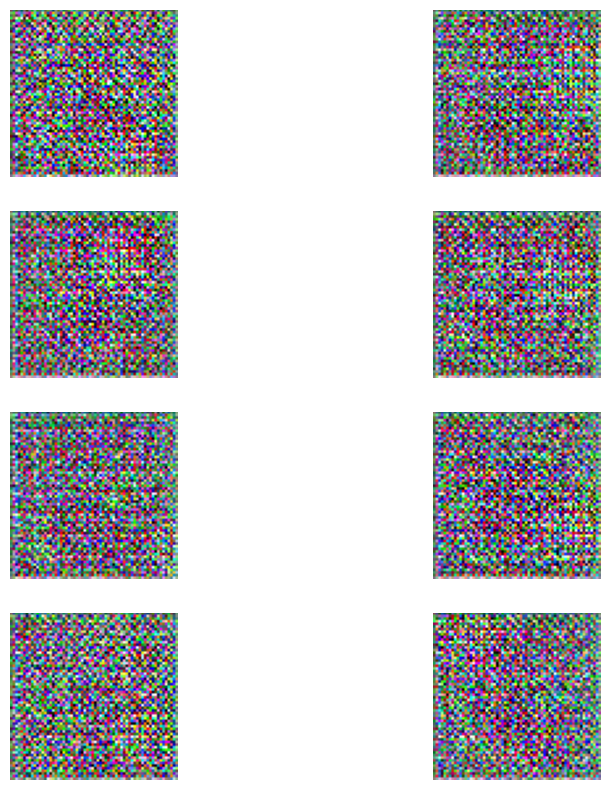

Epoch [1/13] Batch 1500/7131 \ Loss D: 0.9310, Loss G: 1.6833


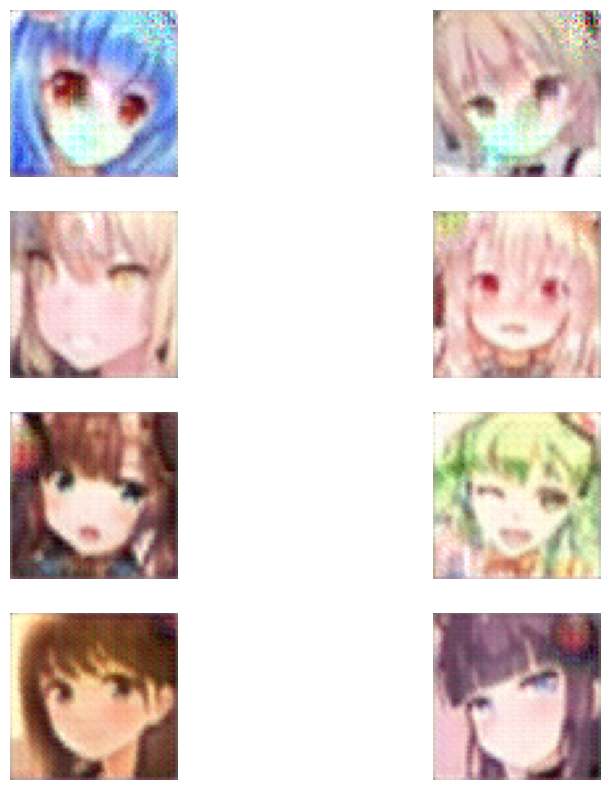

Epoch [1/13] Batch 3000/7131 \ Loss D: 0.1269, Loss G: 4.3746


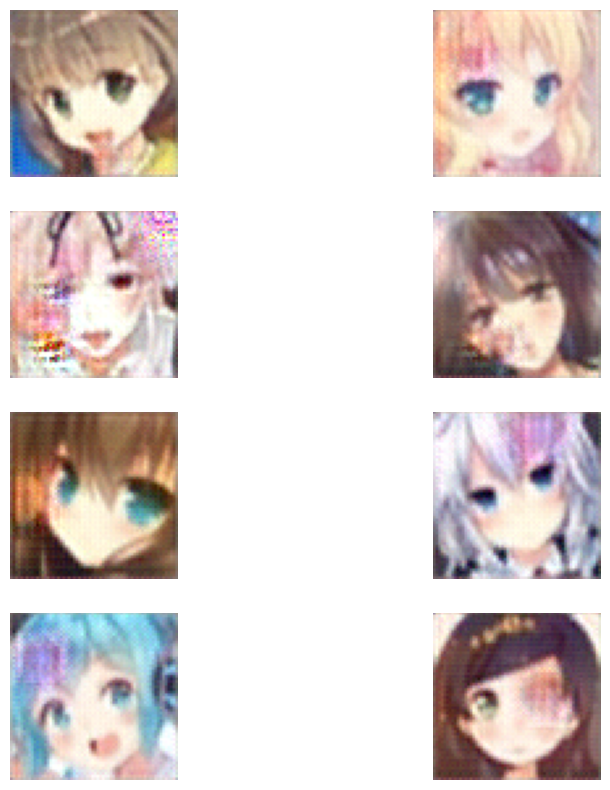

Epoch [1/13] Batch 4500/7131 \ Loss D: 0.4708, Loss G: 2.0047


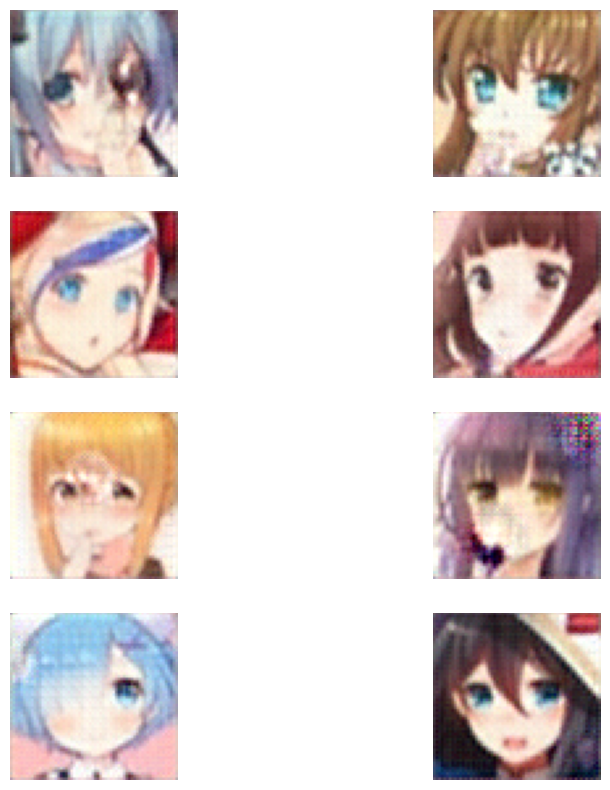

Epoch [1/13] Batch 6000/7131 \ Loss D: 0.1182, Loss G: 2.3754


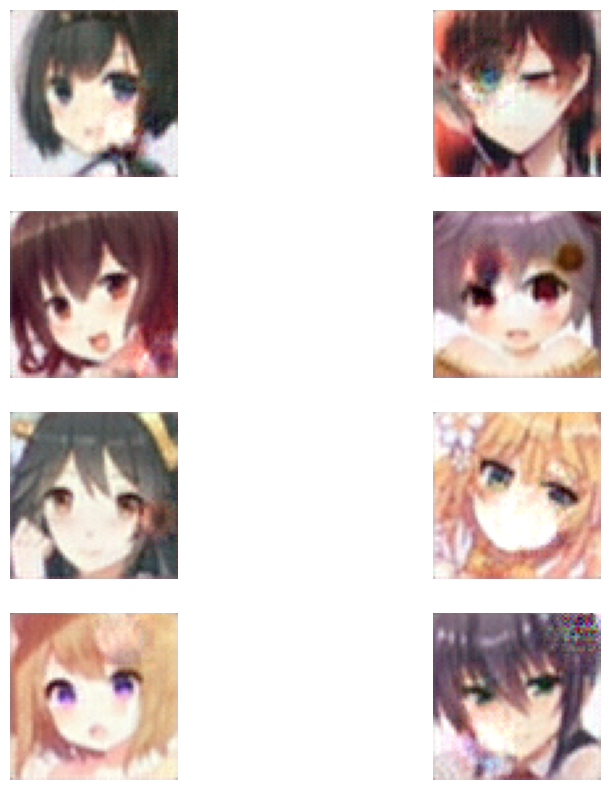

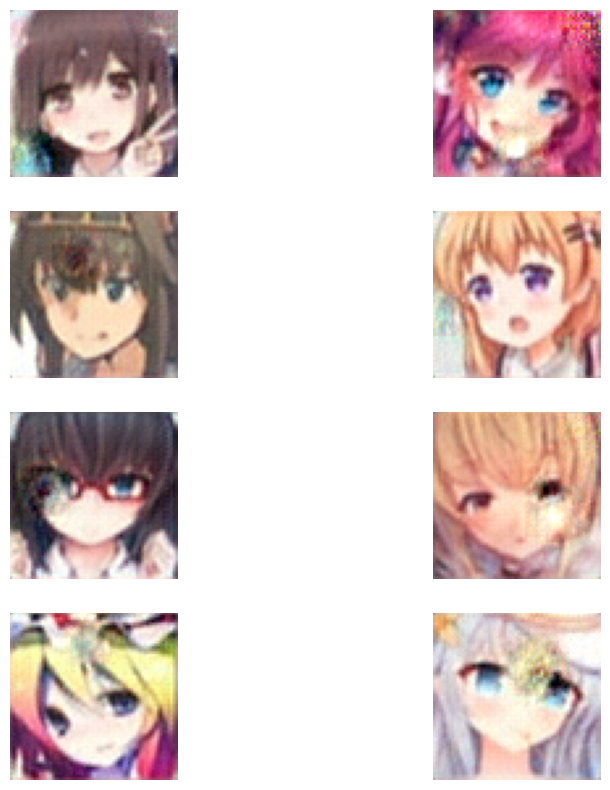

   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch                                      
 2759/7131  00:07:44<00:12:16  5.94it/s  1.1503  1.2097    2                                        

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Epoch [2/13] Batch 0/7131 \ Loss D: 1.2637, Loss G: 1.7739


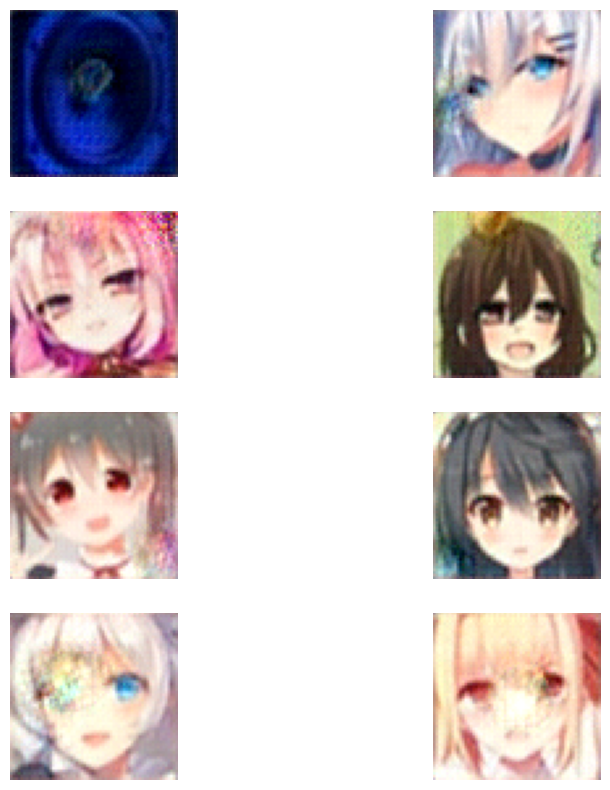

Epoch [2/13] Batch 1500/7131 \ Loss D: 0.5402, Loss G: 1.6836


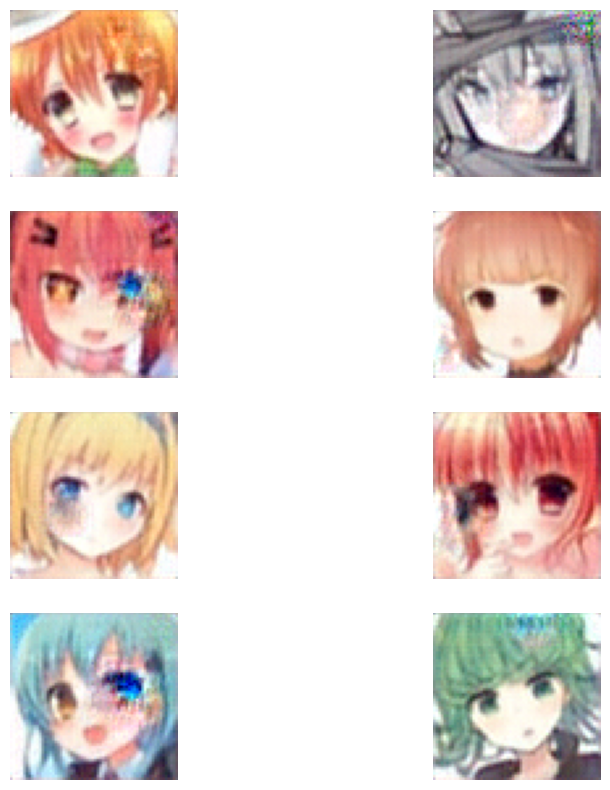

In [ ]:
# 開始訓練
for epoch in range(epochs):
    progress_bar = qqdm(train_loader)
    last_gen_imgs = None  # 儲存最後一個生成的批次

    for i, (real_imgs, stained_imgs, mask) in enumerate(progress_bar):

        # 將資料移動到 GPU 上
        real_imgs, stained_imgs, mask = real_imgs.to(device), stained_imgs.to(device), mask.to(device)
        batch_size = real_imgs.size(0)

        # 創建標籤
        valid = torch.ones(batch_size, 1, requires_grad=False).to(device)  # 真實標籤
        fake = torch.zeros(batch_size, 1, requires_grad=False).to(device)  # 假標籤

        # ---- 訓練生成器 ----
        optimizer_G.zero_grad()

        # 隨機生成噪聲並生成圖像
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z, stained_imgs, mask)
        last_gen_imgs = gen_imgs  # 儲存最後一個批次生成的圖像

        # 計算生成器損失（對抗損失 + 加權的 L1 損失）
        g_adv_loss = adversarial_loss(discriminator(gen_imgs, mask), valid)
        g_l1_loss = l1_loss(gen_imgs, real_imgs)
        g_bd_loss = bd_loss(gen_imgs, stained_imgs, real_imgs, mask)

        g_loss = g_adv_loss + lambda_l1 * g_l1_loss + lambda_bd * g_bd_loss
        # g_loss = g_l1_loss + lambda_bd * g_bd_loss


        # 反向傳播並更新生成器的權重
        g_loss.backward()
        optimizer_G.step()

        # ---- 訓練鑑別器 ----
        optimizer_D.zero_grad()

        # 計算鑑別器損失（對真實圖像和假圖像）
        real_loss = adversarial_loss(discriminator(real_imgs, mask), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), mask), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 反向傳播並更新鑑別器的權重
        d_loss.backward()
        optimizer_D.step()

        # 更新進度條資訊
        progress_bar.set_infos({
            'Loss_D': round(d_loss.item(), 4),
            'Loss_G': round(g_loss.item(), 4),
            'Epoch': epoch + 1,
        })

        # 每隔一定批次儲存生成的圖像
        if i % sample_interval == 0:
            print(f"Epoch [{epoch + 1}/{epochs}] Batch {i}/{len(train_loader)} \ Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")
            # print(f"Epoch [{epoch + 1}/{epochs}] Batch {i}/{len(train_loader)} \ Loss G: {g_loss.item():.4f}")
            save_image(gen_imgs, epoch+1, i)

    # 每個 epoch 儲存最後一批次的生成圖像
    if last_gen_imgs is not None:
        save_image(last_gen_imgs, epoch+1, "latest")


# **Save Model**

In [ ]:
# prompt: 儲存模型

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
files.download('generator.pth')
files.download('discriminator.pth')

if os.path.exists('./val_imgs'):
  # 創建一個新的目錄來存放最新的圖像
  if not os.path.exists('./latest_images'):
      os.makedirs('./latest_images')

  # 複製最新的生成圖像
  for img in glob.glob('./val_imgs/*_iter_latest.png'):
      !cp "$img" ./latest_images/

  # # 壓縮最新圖像
  # !zip -r ./latest_generated_images.zip ./latest_images

  # # 下載壓縮文件
  # files.download('./latest_generated_images.zip')

  # print("已將最新生成的圖像壓縮並開始下載。")


# **Evaluate**

In [ ]:
with torch.no_grad():
    for i, (real_imgs, stained_imgs, mask) in enumerate(test_loader):  # 包含 mask
        real_imgs = real_imgs.to(device)
        stained_imgs = stained_imgs.to(device)
        mask = mask.to(device)

        # 隨機生成噪聲向量
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)

        # 生成最終修復後的圖像（經過 RefineNet）
        final_imgs = generator(z, stained_imgs, mask)

        RMSE_stained, RMSE_non_stained, RMSE_total = rmse(final_imgs.cpu().numpy(), real_imgs.cpu().numpy(), mask.cpu().numpy())

        # 打印各部分的 RMSE
        print("RMSE in stained region: {:.6f}".format(RMSE_stained))
        print("RMSE in non-stained region: {:.6f}".format(RMSE_non_stained))
        print("Total RMSE: {:.6f}".format(RMSE_total))


        # 拼接 stained_imgs 和 final_imgs 做對比
        comparison = torch.cat((stained_imgs, final_imgs), dim=3)  # 在寬度維度拼接

        # 儲存生成的對比圖像
        save_image(comparison, epoch="Test", iter=i)

        # 僅測試一個批次
        if i == 5:
          break


# **Testing**

In [ ]:
from PIL import Image

# 定義預處理函數
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

mask_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # 保留单通道，不做归一化
])

# 加載stained mask圖像
stained_img_path = 'stained.png'
mask_img_path = 'mask.png'

# 加載圖像並預處理
stained_img = Image.open(stained_img_path).convert('RGB')
mask_img = Image.open(mask_img_path).convert('L')

stained_img_tensor = image_transform(stained_img).unsqueeze(0).to(device)  # 添加 batch 維度
mask_tensor = mask_transform(mask_img).unsqueeze(0).to(device)  # 添加 batch 維度

# 生成隨機noise向量
z = torch.randn(1, latent_dim).to(device)

# 使用生成器生成最终图像
generator.eval()  # 切換成評估模式
with torch.no_grad():
    generated_img = generator(z, stained_img_tensor, mask_tensor)

# 加載真實圖像進行對比
real_img_path = 'real.png'
real_img = Image.open(real_img_path).convert('RGB')
real_img_tensor = image_transform(real_img).unsqueeze(0).to(device)

# 計算 RMSE
RMSE_stained, RMSE_non_stained, RMSE_total = rmse(
    generated_img.cpu().detach().numpy(),
    real_img_tensor.cpu().detach().numpy(),
    mask_tensor.cpu().detach().numpy()
)

# 打印 RMSE 结果
print("RMSE in stained region: {:.6f}".format(RMSE_stained))
print("RMSE in non-stained region: {:.6f}".format(RMSE_non_stained))
print("Total RMSE: {:.6f}".format(RMSE_total))

# 可視化結果
# 將生成圖從張亮還原維圖像
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0).detach().cpu()  # 去掉 batch 維度並移到 CPU
    tensor = (tensor * 0.5 + 0.5).clamp(0, 1)
    return transforms.ToPILImage()(tensor)

generated_img_pil = tensor_to_image(generated_img)
generated_img_pil.show(title="Generated Image")

real_img_pil = tensor_to_image(real_img_tensor)
real_img_pil.show(title="Real Image")
# plt.show(real_img_pil)
generated_img_pil.save('output_generated.png')



RMSE in stained region: 0.090324
RMSE in non-stained region: 0.575655
Total RMSE: 0.583770
